# Crop Type Classification

some intro... and we import all required modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

## 1. Have a look at the data
We prepared some files with the training and testing data. Let's load them with pandas in [Dataframes](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html#dataframe) (kind of a tabular data structure):

As we can see, we have four data sources:
3. Original Sentinel-2 data: 6 reflectance bands for each sample from May until October 2020. Clouds are masked out with the error value -9999.
4. Smoothed Sentinel-2 data: These are the same reflectances like from above but smoothed using the [Whittaker filter](https://ieeexplore.ieee.org/document/8076705/;jsessionid=qztFzkimDKC3cFh9jnq4bdysCDDBHU3XBckrypTVsSQhFbezneYl!-873444045), i.e. all cloud-masked values will be replaced by interpolated values. This product was triggered through the BETTER pipelines.



### Groundtruth
This contains the crop type for each sample.

In [2]:
groundtruth = pd.read_csv("data/groundtruth.csv")
crop_names = np.unique(groundtruth.crop_type.values)

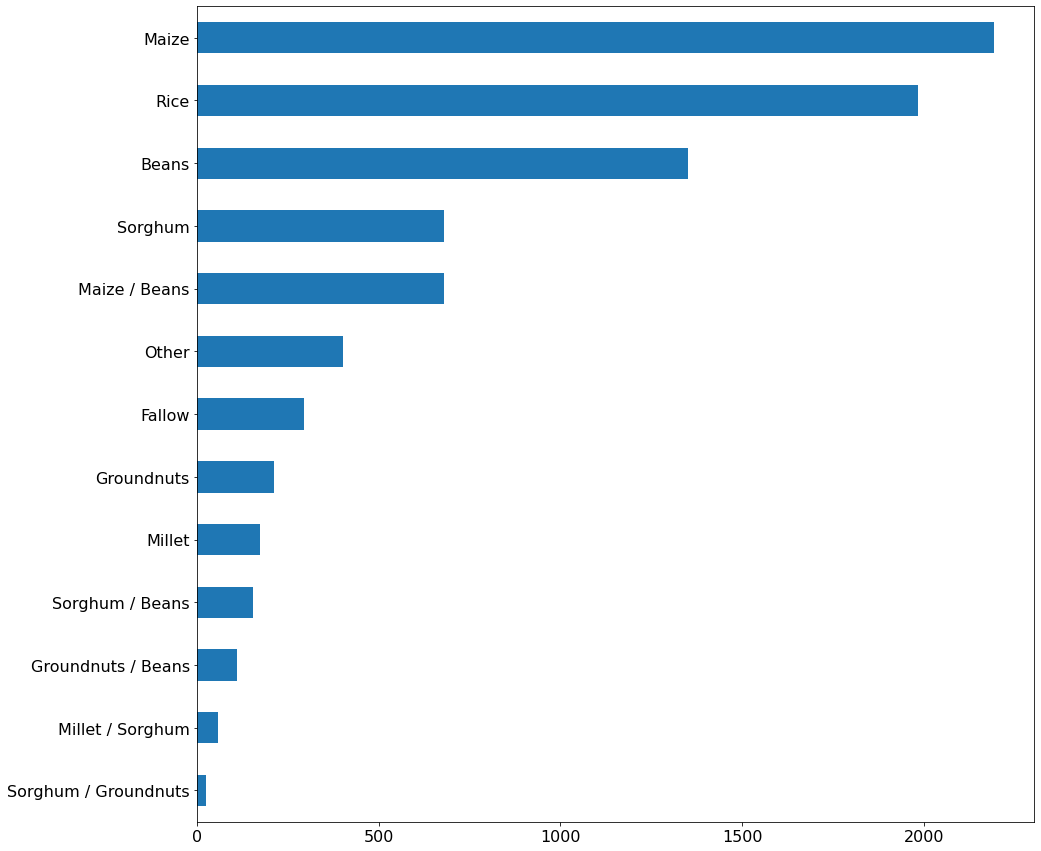

In [3]:
ax = groundtruth.crop_type.value_counts().plot.barh(figsize=(15, 15), fontsize=16)
ax.invert_yaxis()

### Sentinel-1 data, linearly interpolated
Sentinel-1 backscatter for each sample from May until October 2020.

In [4]:
s1_linear = list(
    map(pd.read_csv, 
         [
            "data/S1_VV_train_linear.csv",
            "data/S1_VH_train_linear.csv",
        ]))

### Sentinel-1 data, smoothed by using the Whittaker filter
Sentinel-1 backscatter for each sample from May until October 2020.

In [5]:
s1_whittaker = list(
    map(pd.read_csv, 
         [
            "data/S1_VV_train_whittaker.csv",
            "data/S1_VH_train_whittaker.csv",
        ]))

### Sentinel-2 data, linearly interpolated
9 reflectance bands for each sample from May until October 2020.

In [6]:
s2_linear = list(
    map(pd.read_csv, 
         [
            "data/S2_B2_train_linear.csv",
            "data/S2_B3_train_linear.csv",
            "data/S2_B4_train_linear.csv",
            "data/S2_B5_train_linear.csv",
            "data/S2_B6_train_linear.csv",
            "data/S2_B7_train_linear.csv",
            "data/S2_B8_train_linear.csv",
            "data/S2_B11_train_linear.csv",
            "data/S2_B12_train_linear.csv",
        ]))

### Sentinel-2 data, smoothed by using the Whittaker filter
These are the same reflectances like from above but smoothed using the [Whittaker filter](https://ieeexplore.ieee.org/document/8076705/;jsessionid=qztFzkimDKC3cFh9jnq4bdysCDDBHU3XBckrypTVsSQhFbezneYl!-873444045). This product was triggered through the BETTER pipelines.

In [7]:
s2_whittaker = list(
    map(pd.read_csv, 
         [
            "data/S2_B2_train_whittaker.csv",
            "data/S2_B3_train_whittaker.csv",
            "data/S2_B4_train_whittaker.csv",
            "data/S2_B5_train_whittaker.csv",
            "data/S2_B6_train_whittaker.csv",
            "data/S2_B7_train_whittaker.csv",
            "data/S2_B8_train_whittaker.csv",
            "data/S2_B11_train_whittaker.csv",
            "data/S2_B12_train_whittaker.csv",
        ]))

## 2. Combine the input features for the model:
We don't have to use all available resources:

In [8]:
data = pd.concat([groundtruth] + s2_linear + s1_whittaker, axis=1)
data

,crop_type,polygon_ids,20200506,20200511,20200516,20200521,20200526,20200531,20200605,20200610,...,20200821,20200826,20200902,20200907,20200914,20200919,20200926,20201001,20201008,20201013
0,Rice,627,0.1676,0.1599,0.1634,-9999.0,0.1621,-9999.0,0.1568,-9999.0,...,-16.915130,-16.641247,-16.386941,-16.146587,-15.919142,-15.703561,-15.495628,-15.291128,-15.088344,-14.885561
1,Rice,627,0.1661,0.1503,0.1562,-9999.0,0.1537,-9999.0,0.1458,-9999.0,...,-16.407606,-16.242709,-16.112212,-16.011070,-15.936524,-15.885815,-15.850885,-15.823674,-15.800324,-15.776973
2,Rice,627,0.1645,0.1497,0.1505,-9999.0,0.1566,-9999.0,0.1407,-9999.0,...,-16.157491,-15.820782,-15.501466,-15.195813,-14.901286,-14.615351,-14.334054,-14.053441,-13.773170,-13.492900
3,Rice,627,0.1642,0.1527,0.1575,-9999.0,0.1643,-9999.0,0.1490,-9999.0,...,-17.006949,-16.459709,-15.925519,-15.413249,-14.916936,-14.430615,-13.949942,-13.470576,-12.991863,-12.513149
4,Rice,627,0.1662,0.1529,0.1646,-9999.0,0.1674,-9999.0,0.1553,-9999.0,...,-15.975083,-15.587687,-15.215253,-14.862576,-14.530132,-14.218398,-13.919766,-13.626629,-13.336239,-13.045849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317,Rice,627,0.1750,0.1689,0.1815,-9999.0,0.1527,-9999.0,0.1618,-9999.0,...,-13.211985,-12.818842,-12.431339,-12.047402,-11.666915,-11.289758,-10.916697,-10.548498,-10.182729,-9.816960
8318,Rice,627,0.1737,0.1655,0.1758,-9999.0,0.1508,-9999.0,0.1617,-9999.0,...,-16.904916,-16.583154,-16.248979,-15.902247,-15.545538,-15.181433,-14.815581,-14.453634,-14.093640,-13.733645
8319,Rice,627,0.1739,0.1639,0.1696,-9999.0,0.1536,-9999.0,0.1560,-9999.0,...,-15.687512,-15.513616,-15.370119,-15.247709,-15.143359,-15.054044,-14.975024,-14.901556,-14.830864,-14.760172
8320,Rice,627,0.1663,0.1575,0.1605,-9999.0,0.1487,-9999.0,0.1524,-9999.0,...,-14.898548,-14.756480,-14.658613,-14.595749,-14.559854,-14.542891,-14.538165,-14.538980,-14.542566,-14.546152


## 3. Data preprocessing
Before training the model, we have to split the dataset into training and testing partitions. *Training data* will be used to actually train the model and the *testing data* is used to estimate the model's performance in the real world.
We split along the original polygons the data came from. By doing this we make sure we don't mix-up training and testing data.

In [9]:
# stratifying the samples means that we have the same crop types in the training as in the testing dataset
train, test = [], []

for crop_name in crop_names:
    polygons_with_this_crop = np.unique(data.polygon_ids.loc[data.crop_type==crop_name])
    train_polygons, test_polygons = train_test_split(polygons_with_this_crop)
    train.append(data.loc[data.polygon_ids.isin(train_polygons)])
    test.append(data.loc[data.polygon_ids.isin(test_polygons)])
train = pd.concat(train)
test = pd.concat(test)

We need to transform the string representation of the crop type label into numerical values

In [10]:
label_encoder = OrdinalEncoder()
label_encoder.fit(data.crop_type.values.reshape(-1, 1))

train_labels = label_encoder.transform(train.crop_type.values.reshape(-1, 1))
test_labels = label_encoder.transform(test.crop_type.values.reshape(-1, 1))

## 4. Train the model
Let's train the model! You can change all hyperparameters later to further improve you own model version

In [11]:
model = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, random_state=0)
model.fit(train.drop(columns=["crop_type", "polygon_ids"]), train_labels)

/home/john/anaconda3/envs/wfp-notebooks/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(n_estimators=50, random_state=0)

## 5. Evaluate the model
How well did the model perform? Which classes are still mislabeled? Let's use a confusion matrix to find out. If you see that your model does not perform well, you might change hyperparameters, model type or even the input combinations.

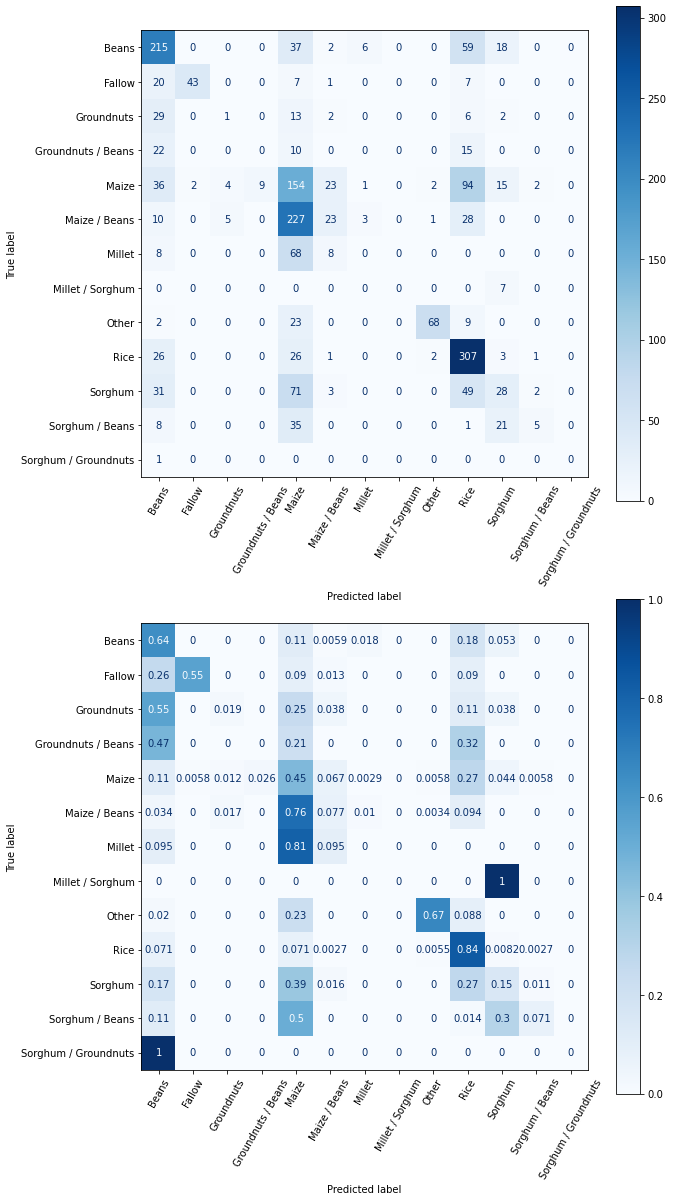

In [12]:
fig, axes = plt.subplots(2, figsize=(10, 20))
plot_confusion_matrix(
    model, 
    test.drop(columns=["crop_type", "polygon_ids"]), 
    test_labels,
    display_labels=crop_names,
    cmap=plt.cm.Blues,
    normalize=None, ax=axes[0]
)
axes[0].tick_params(axis='x', labelrotation=60)
plot_confusion_matrix(
    model, 
    test.drop(columns=["crop_type", "polygon_ids"]), 
    test_labels,
    display_labels=crop_names,
    cmap=plt.cm.Blues,
    normalize='true', ax=axes[1]
)
axes[1].tick_params(axis='x', labelrotation=60)

## 6. Run the model on our data and sumbit the predictions
**ONLY CONTINUE HERE AFTER TRAINING AND FINE-TUNING YOUR MODEL SEVERAL TIMES**

If you think your model is good enough, you can let it run on the final validation data. Submit us the file with your predictions and we will see how your model performed.
At first, we have to load the validation data from disk. Make sure that you oly use the input features which you used to train your model from above!

In [13]:
s1_linear_validation = list(
    map(pd.read_csv, 
         [
            "data/S1_VV_validation_linear.csv",
            "data/S1_VH_validation_linear.csv",
        ]))

In [14]:
s1_whittaker_validation = list(
    map(pd.read_csv, 
         [
            "data/S1_VV_validation_whittaker.csv",
            "data/S1_VH_validation_whittaker.csv",
        ]))

In [15]:
s2_linear_validation = list(
    map(pd.read_csv, 
         [
            "data/S2_B2_validation_linear.csv",
            "data/S2_B3_validation_linear.csv",
            "data/S2_B4_validation_linear.csv",
            "data/S2_B5_validation_linear.csv",
            "data/S2_B6_validation_linear.csv",
            "data/S2_B7_validation_linear.csv",
            "data/S2_B8_validation_linear.csv",
            "data/S2_B11_validation_linear.csv",
            "data/S2_B12_validation_linear.csv",
        ]))

In [16]:
s2_whittaker_validation = list(
    map(pd.read_csv, 
         [
            "data/S2_B2_validation_whittaker.csv",
            "data/S2_B3_validation_whittaker.csv",
            "data/S2_B4_validation_whittaker.csv",
            "data/S2_B5_validation_whittaker.csv",
            "data/S2_B6_validation_whittaker.csv",
            "data/S2_B7_validation_whittaker.csv",
            "data/S2_B8_validation_whittaker.csv",
            "data/S2_B11_validation_whittaker.csv",
            "data/S2_B12_validation_whittaker.csv",
        ]))

In [17]:
validation_data = pd.concat(s2_linear_validation + s1_whittaker_validation, axis=1)
validation_data

,20200506,20200511,20200516,20200521,20200526,20200531,20200605,20200610,20200615,20200620,...,20200821,20200826,20200902,20200907,20200914,20200919,20200926,20201001,20201008,20201013
0,0.1462,0.1616,-9999.0,-9999.0,0.1754,-9999.0,-9999.0,0.1613,-9999.0,0.1288,...,-15.981783,-15.714187,-15.465814,-15.237624,-15.030574,-14.848673,-14.695930,-14.560329,-14.429852,-14.301938
1,0.1532,0.1704,-9999.0,-9999.0,0.1756,-9999.0,-9999.0,0.1678,-9999.0,0.1268,...,-17.009520,-16.889747,-16.800996,-16.738985,-16.699428,-16.679087,-16.674722,-16.681944,-16.696364,-16.714384
2,0.1510,0.1838,-9999.0,-9999.0,0.1888,-9999.0,-9999.0,0.1714,-9999.0,0.1266,...,-17.431934,-17.271081,-17.108225,-16.940140,-16.763598,-16.578382,-16.384277,-16.183365,-15.977733,-15.769740
3,0.1384,0.1596,-9999.0,-9999.0,0.1781,-9999.0,-9999.0,0.1446,-9999.0,0.1187,...,-16.462792,-16.222116,-15.976508,-15.726485,-15.472565,-15.215576,-14.956347,-14.696349,-14.437056,-14.178115
4,0.1401,0.1710,-9999.0,-9999.0,0.1784,-9999.0,-9999.0,0.1587,-9999.0,0.1152,...,-14.177470,-14.068703,-13.985772,-13.925047,-13.882898,-13.856723,-13.843918,-13.842286,-13.849628,-13.861456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,0.1466,0.1569,-9999.0,-9999.0,0.1901,-9999.0,-9999.0,0.1604,-9999.0,0.1234,...,-17.259804,-16.967681,-16.669725,-16.368224,-16.065462,-15.764878,-15.469911,-15.179284,-14.891721,-14.605690
1048,0.1395,0.1615,-9999.0,-9999.0,0.1706,-9999.0,-9999.0,0.1420,-9999.0,0.1200,...,-16.815571,-16.465950,-16.125417,-15.791739,-15.462687,-15.137742,-14.816389,-14.498630,-14.184466,-13.872100
1049,0.1508,0.1716,-9999.0,-9999.0,0.1810,-9999.0,-9999.0,0.1641,-9999.0,0.1244,...,-16.906709,-16.571413,-16.259460,-15.965562,-15.684427,-15.412445,-15.146005,-14.884410,-14.626963,-14.371589
1050,0.1530,0.1746,-9999.0,-9999.0,0.1825,-9999.0,-9999.0,0.1674,-9999.0,0.1335,...,-17.766957,-17.401999,-17.034438,-16.664938,-16.294166,-15.925727,-15.563225,-15.206356,-14.854818,-14.505944


Let your model predict the crop types for the validation data:

In [18]:
validation_predictions = label_encoder.inverse_transform(model.predict(validation_data).reshape(-1, 1))


Save the predictions to disk and send us the file so we can check how your model performed.

In [19]:
pd.Series(np.squeeze(validation_predictions), name="crop_type").to_csv("MY_NAME_predictions.csv", index=False)